# Assignment2 - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [1]:
# stundent details:
# Michael O J 5140
# Agam M 6895

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 


AI agent name 2:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 

Other assistanse:    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>




    
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

In [3]:
df1 = pd.read_csv("housing_test.csv")
df2 = pd.read_csv("housing_train.csv")

In [4]:
df1.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,5.3254,32.0,5.786260,1.033079,982.0,2.498728,34.29,-119.27,3.852
1,5.3032,52.0,5.095745,1.028369,980.0,3.475177,34.08,-118.12,2.457
2,4.1679,41.0,6.617486,1.371585,915.0,2.500000,37.05,-122.05,2.013
3,3.6429,28.0,5.249180,1.009836,848.0,2.780328,38.69,-121.41,1.052
4,2.7457,17.0,11.183267,2.107570,675.0,2.689243,38.88,-119.99,1.078


In [5]:
df2.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,4.0179,46.0,4.158690,1.032746,512.0,1.289673,34.07,-118.35,3.500
1,2.7002,6.0,4.149245,1.179989,4092.0,2.287311,34.05,-117.31,0.883
2,1.2762,17.0,3.432331,1.022556,1325.0,2.490602,34.42,-119.69,2.536
3,4.9342,23.0,5.735798,1.053201,4580.0,4.129847,34.04,-117.93,1.810
4,2.2755,21.0,4.064607,0.962079,2109.0,2.962079,32.58,-117.11,1.250


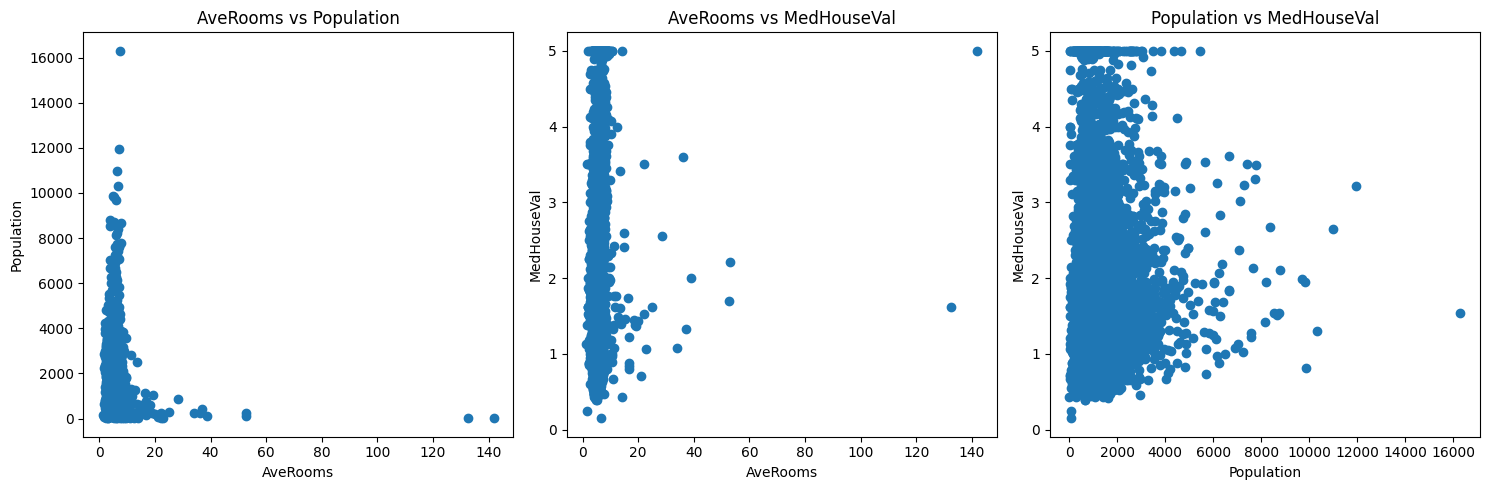

In [6]:
figure, axes = plt.subplots(1, 3, figsize=(15, 5))

col1, col2, col3 = "AveRooms", "Population", "MedHouseVal"

axes[0].scatter(df1[col1], df1[col2])
axes[0].set_xlabel(col1)
axes[0].set_ylabel(col2)
axes[0].set_title(f'{col1} vs {col2}')

axes[1].scatter(df1[col1], df1[col3])
axes[1].set_xlabel(col1)
axes[1].set_ylabel(col3)
axes[1].set_title(f'{col1} vs {col3}')

axes[2].scatter(df1[col2], df1[col3])
axes[2].set_xlabel(col2)
axes[2].set_ylabel(col3)
axes[2].set_title(f'{col2} vs {col3}')

plt.tight_layout()
plt.show()

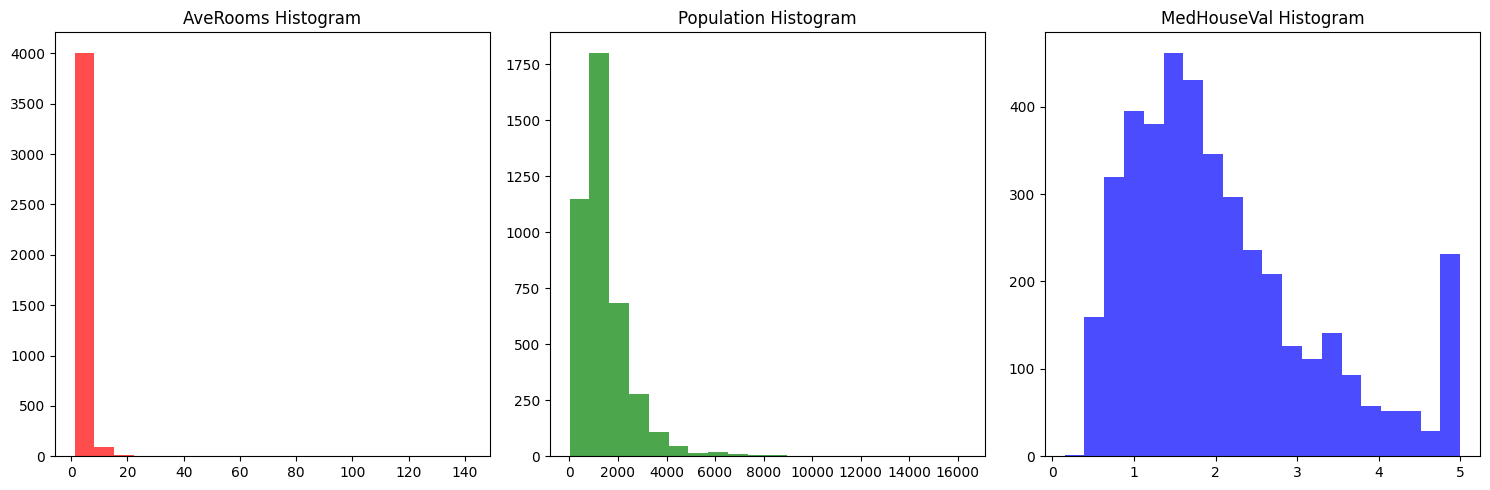

In [7]:
figure , axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df1[col1], bins=20, color='red', alpha=0.7)
axes[0].set_title(f'{col1} Histogram')
#מטרה לראות את הקשר בין כמות אוכלסיה לכמות ממוצעות של חדרים לבדוק אם יש קשר בין השניים
# ככל שהאוכלסיה גדלה כך ממוצע החדרים ירד

axes[1].hist(df1[col2], bins=20, color='green', alpha=0.7)
axes[1].set_title(f'{col2} Histogram')
# להראות את הקשר בין כמות החדרים לבין מחירי הבתים
# לא קיים קשר בין כמות חדרים לבין מחיר הדירה

axes[2].hist(df1[col3], bins=20, color='blue', alpha=0.7)
axes[2].set_title(f'{col3} Histogram')

# להראות את השר בין כמות אוכלוסייה לבין מחירי הבתים
# קיים קשר חלש  בין כמות אוכלוסיה לבין מחיר הדיור

plt.tight_layout()
plt.show()

## Part 3 - Experiments
You could add as many code cells as needed

In [11]:
# Feature engineering options
feature_options = [
    [],  # No transformation
    ['scale'],  # Standard scaling
    ['poly2'],  # Polynomial degree 2
    ['scale', 'poly2']  # Scaling + polynomial
]

# Models and their hyperparameters
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {'model__alpha': [0.1, 1, 10]}
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5, None]}
    }
}

results = []

X = df2.drop('MedHouseVal', axis=1)
y = df2['MedHouseVal']

In [ ]:
for feats in feature_options:
    steps = []
    feats_name = []
    if 'scale' in feats:
        steps.append(('scaler', StandardScaler()))
        feats_name.append('scale')
    if 'poly2' in feats:
        steps.append(('poly', PolynomialFeatures(degree=2, include_bias=False)))
        feats_name.append('poly2')
    for model_name, model_dict in models.items():
        pipe_steps = steps + [('model', model_dict['model'])]
        pipe = Pipeline(pipe_steps)
        param_grid = model_dict['params']
        # GridSearchCV with 5-fold cross-validation
        grid = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(mean_squared_error, greater_is_better=False), n_jobs=-1)
        grid.fit(X, y)
        results.append({
            'Feature Engineering': '+'.join(feats_name) if feats_name else 'none',
            'Model': model_name,
            'Best Params': grid.best_params_,
            'CV Mean MSE': -grid.best_score_,
            'R² Score':  grid.best_estimator_.score(X, y)  # Calculate R^2 using fit.score
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('CV Mean MSE')
display(results_df)

C:\Users\agamm\PycharmProjects\Global venv\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.53955e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

## Part 5 - Apply on test and show model performance estimation